# Feature selection tutorial

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so


In [3]:
# Add autoreload for easier development
%load_ext autoreload
%autoreload 2
from tcrpeg_toolkit.p_infer_model_evaluation import PinferCalculation
from tcrpeg.evaluate import evaluation
from tcrpeg.TCRpeg import TCRpeg
from tcrpeg_toolkit.plot_heatmap_pinfer import process_numpy_files

In [ ]:
#write a loop to loop over all models and calculate the p_infer

# List all models in the directory
files_models = os.listdir('/Users/vanessamhanna/Nextcloud/TCRpeg/models/')
# Filter for carto 27 files
models = [i for i in files_models if '-27' in i]

# List all embeddings files in the directory
files_embeddings = os.listdir('/Users/vanessamhanna/Nextcloud/TCRpeg/embeddings/txt/')
# Filter for carto 27 files
embeddings = [i for i in files_embeddings if '-27' in i]

# List all data files
files_data = os.listdir('/Users/vanessamhanna/Nextcloud/TCRpeg/data/')
#filter for carto 27
data = [i for i in files_data if '27' in i]

#iterate over each model, embedding and data file and apply PinferCalculation function

for model in models:
    model_file = '/Users/vanessamhanna/Nextcloud/TCRpeg/models/' + model
    name_models = os.path.basename(model_file).split('.pth')[0]
    
    output_dir = '/Users/vanessamhanna/Nextcloud/TCRpeg/'
    
    for embedding in embeddings:
        embedding_file = '/Users/vanessamhanna/Nextcloud/TCRpeg/embeddings/txt/' + embedding
        name_embeddings = os.path.basename(embedding_file).split('_aa.txt')[0]

        if name_models == name_embeddings:
            for data_file in data:
                sequence_file = '/Users/vanessamhanna/Nextcloud/TCRpeg/data/' + data_file
            
                pop_data = os.path.basename(sequence_file).split('-')[2]
                pop_models = os.path.basename(model_file).split('-')[2]
                

                if pop_data == pop_models:
                    p_infer_model = PinferCalculation(model_file=model_file,
                            embedding_file=embedding_file,
                            sequence_file=sequence_file,
                            output_dir=output_dir)
        
                    p_infer_model.run(hidden_size=128, num_layers=5)

In [5]:
# read structured array
# structured_data = process_numpy_files('/Users/vanessamhanna/Nextcloud/TCRpeg/model_evaluation/BLN-27-amTregs-TRB/', use_structured_array=False)
path = '/Users/vanessamhanna/Nextcloud/TCRpeg/model_evaluation/'

# Initialize final lists to collect data from all folders
sequence_final=[]
pinfer_final = []
sample_ids_final=[]
model_id_final=[]

# Iterate over each folder in the specified directory
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):
            # Initialize lists to collect data from the current folder
            sequence_list = []
            pinfer_list = []
            sample_ids = []
            model_id = []
            # Iterate over each file in the current folder
            for file_name in os.listdir(folder_path):
                    if file_name.endswith('.npy'):
                        file_path = os.path.join(path, folder, file_name)
                        sample_name = file_name.split('-TRB_structured_pinfer')[0]
                        data= np.load(file_path)
                        sequence_list.extend(data['sequence'])
                        pinfer_list.extend(data['pinfer'])
                        sample_ids.extend(np.repeat(sample_name, len(data['sequence'])))
                        model_id.extend(np.repeat(folder, len(data['sequence'])))
                        
            # Append the collected data from the current folder to the final lists
            sequence_final.extend(sequence_list)
            pinfer_final.extend(pinfer_list)
            sample_ids_final.extend(sample_ids)
            model_id_final.extend(model_id)

# Define the dtype for the structured array
dtype = [('sample_id', 'U50'), ('model_id', 'U50'), ('sequence', 'U50'), ('pinfer', 'f4')]

# Create the structured array with the collected data
structured_array = np.array(list(zip(sample_ids_final, model_id_final, sequence_final, pinfer_final)), dtype=dtype)

# Print the structured array
print(structured_array)

[('SPL-27-nTregs', 'ILN-27-nTregs-TRB', 'CAAARGAETLYF', 1.6074548e-05)
 ('SPL-27-nTregs', 'ILN-27-nTregs-TRB', 'CAADGGDSYEQYF', 1.9823678e-06)
 ('SPL-27-nTregs', 'ILN-27-nTregs-TRB', 'CAAERLGNTGQLYF', 6.2499383e-09)
 ... ('PLN-27-nTregs', 'PALN-27-nTregs-TRB', 'WEAYNSPLYF', 2.2859270e-08)
 ('PLN-27-nTregs', 'PALN-27-nTregs-TRB', 'WSNERLFF', 3.8061216e-06)
 ('PLN-27-nTregs', 'PALN-27-nTregs-TRB', 'YASSPTGGQNTLYF', 4.0269956e-06)]


In [7]:
df = pd.DataFrame(structured_array)

# Save the DataFrame to a CSV file
df.to_csv('/Users/vanessamhanna/Nextcloud/TCRpeg/model_evaluation/structured_data.csv', index=False)


In [8]:
#filter df
filtered_df = df[~df['sample_id'].str.contains('SPL')]


In [10]:
lists_f= []
for i in filtered_df['sample_id'].unique():
    data_d = filtered_df[filtered_df['sample_id']==i]
    data_d = data_d.pivot_table(index=['sample_id', 'sequence'], columns='model_id', values='pinfer', aggfunc='first').reset_index()
    data_d.columns.name = None
    data_d = data_d.reset_index(drop=True)
    check_col = i + '-TRB'
    
    def check_row(row):
            check_value = row[check_col]
            other_values = row.drop(labels=['sample_id', 'sequence', check_col]).values
            return np.where(check_value > np.max(other_values), 'keep', 'remove')
  
    data_d['result'] = data_d.apply(check_row, axis=1)
    lists_f.append(data_d[['sample_id', 'sequence', 'result']])

df_f = pd.concat(lists_f, ignore_index=True)

In [333]:
# Group by 'sample_id' and 'result' and count occurrences
df_f['sample_id'] = df_f['sample_id'].astype(str)
df_f['result'] = df_f['result'].astype(str)

lists_cnt = df_f.groupby(['sample_id', 'result']).size().reset_index(name='count')

# Group by 'sample_id' and calculate proportions
lists_cnt['prop'] = lists_cnt.groupby('sample_id')['count'].transform(lambda x: x / x.sum())

# Extract 'cell_pop' and 'organ' from 'sample_id'
lists_cnt['cell_pop'] = lists_cnt['sample_id'].str.split('-').apply(lambda x: x[2])
lists_cnt['organ'] = lists_cnt['sample_id'].str.split('-').apply(lambda x: x[0])

# Print the final DataFrame to verify
print(lists_cnt)

          sample_id  result   count      prop cell_pop organ
0        BLN-27-CD8    keep    1630  0.066847      CD8   BLN
1        BLN-27-CD8  remove   22754  0.933153      CD8   BLN
2       BLN-27-Teff    keep   18150  0.123577     Teff   BLN
3       BLN-27-Teff  remove  128722  0.876423     Teff   BLN
4    BLN-27-amTregs    keep    1999  0.036228  amTregs   BLN
5    BLN-27-amTregs  remove   53180  0.963772  amTregs   BLN
6     BLN-27-nTregs    keep    8334  0.090958   nTregs   BLN
7     BLN-27-nTregs  remove   83291  0.909042   nTregs   BLN
8        ILN-27-CD8    keep    6934  0.070788      CD8   ILN
9        ILN-27-CD8  remove   91020  0.929212      CD8   ILN
10      ILN-27-Teff    keep   16720  0.113480     Teff   ILN
11      ILN-27-Teff  remove  130619  0.886520     Teff   ILN
12   ILN-27-amTregs    keep    1130  0.025992  amTregs   ILN
13   ILN-27-amTregs  remove   42345  0.974008  amTregs   ILN
14    ILN-27-nTregs    keep    1097  0.048544   nTregs   ILN
15    ILN-27-nTregs  rem

In [1]:
# Filter the DataFrame
filtered_df = lists_cnt[(lists_cnt['result'] == 'keep') & (lists_cnt['cell_pop'] != 'CD8')]

# Create the plot
g = sns.FacetGrid(filtered_df, col='organ', sharey=False)
g.map_dataframe(sns.barplot, x='cell_pop', y='prop', hue='cell_pop', dodge=False)

# Customize the plot
g.set_axis_labels('Cell Population', 'Proportion')
g.set_titles(col_template='{col_name}')
g.set_xticklabels(rotation=90)
g.add_legend()

# Show the plot
plt.show()

NameError: name 'lists_cnt' is not defined

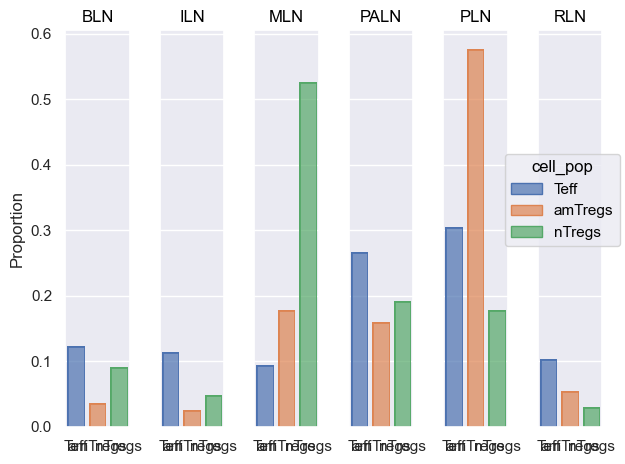

In [360]:
# Create the plot using seaborn.objects
p = (
    so.Plot(filtered_df, x='cell_pop', y='prop', color='cell_pop')
    .add(so.Bar(), so.Agg())
    .facet('organ')
    .label(x='', y='Proportion')
)

p.show()
